In [1]:
import numpy as np
import hera_pspec as hp
import healpy as hlp
from pyuvdata import UVData
import copy, os, itertools, inspect
import matplotlib.pyplot as plt
from hera_pspec.data import DATA_PATH
import scipy.integrate as integrate
import itertools  
from scipy.stats import multivariate_normal
import astropy.units as u

In [2]:
#Define function to create 2D array of k vectors. 
def k_2d_array(r_1d_shape,k_1d):
    return np.transpose(np.tile(k_1d,(r_1d_shape,1,1)),(1, 0, 2))

In [3]:
#Define function to create 2D array of r vectors.
def r_2d_array(k_1d_shape,r_1d):
    return np.tile(r_1d,(k_1d_shape,1,1)) 

In [4]:
#Define function to create 2D array of frequency values.
def mu_2d_array(r_1d_shape,mu_1d):
    return np.tile(mu_1d,(r_1d_shape,1)) 

In [5]:
#Define function to create matrix of all possible F function values. 
def calculate_f_func(r_2d,k_2d,average_mu):
    #np.multiply multiplies the components of each combination of k and r
    #element-wise, then np.sum is used to sum over the indices as would be 
    #done for a dot product between two vectors.
    #z = cosmo.f2z(average_mu)
    k_dot_r = np.sum(np.multiply(k_2d,r_2d),axis=2)
    f = np.exp(k_dot_r*1j)
    return f
    

In [6]:
def calculate_g_func(r_2d_mu_dim,mu_2d,b_vector,tau,beam_array):
    #Define c the speed of light
    c = 3*10**8
    exponent = -2*np.pi*np.sum(np.multiply(b_vector,r_2d_mu_dim),axis=2)/c-tau
    g = np.exp(mu_2d * exponent *1j)*beam_array
    return g

In [7]:
#We need an array of r vectors with appropriate dimensions 
#to multiply with the frequency array element-wise
def r_2d_for_mu_array(mu_1d_shape,r_1d):
    return np.transpose(np.tile(r_1d,(mu_1d_shape,1,1)),(1,0,2))

In [8]:
def get_bsl_vector(baseline):
    antpos = uvd.antenna_positions
    ant1 = np.argwhere(uvd.antenna_numbers==baseline[0])[0][0]
    ant2 = np.argwhere(uvd.antenna_numbers==baseline[1])[0][0]
    bl_vec = antpos[ant1] - antpos[ant2]
    print("baseline vector : ",bl_vec,"separation distance : ",np.sqrt(bl_vec[0]**2+bl_vec[1]**2))
    return bl_vec

In [9]:
#This function is simply used to print out the shapes of the area. It is not necessary to have it.
def print_array_shapes(list_array_shapes,name_arrays):
    for shape,name in zip(list_array_shapes,name_arrays):
        if len(shape)==3:
            print(name+"shape is "+ str(shape[0])+" rows by "+ str(shape[1])+ " columns by "+str(shape[2])+" depth.")
        if len(shape)==2:
            print(name+"shape is "+ str(shape[0])+" rows by "+ str(shape[1])+ " columns.")
        if len(shape)==1:
            print(name+"length is "+ str(shape[0]))

In [10]:
# This function was taken from aipy and it involves creating the rotation matrix
# that will be multiplied by the baseline vector to know the baseline as a function of time
def rot_m(ang, vec):
    """Return 3x3 matrix defined by rotation by 'ang' around the
    axis 'vec', according to the right-hand rule.  Both can be vectors,
    returning a vector of rotation matrices.  Rotation matrix will have a
    scaling of |vec| (i.e. normalize |vec|=1 for a pure rotation)."""
    c = np.cos(ang); s = np.sin(ang); C = 1-c
    x,y,z = vec[...,0], vec[...,1], vec[...,2]
    xs,ys,zs = x*s, y*s, z*s
    xC,yC,zC = x*C, y*C, z*C
    xyC,yzC,zxC = x*yC, y*zC, z*xC
    rm = np.array([[x*xC+c, xyC-zs, zxC+ys],
                   [xyC+zs, y*yC+c, yzC-xs],
                   [zxC-ys, yzC+xs, z*zC+c]], dtype=np.double)
    if rm.ndim > 2:
        axes = list(range(rm.ndim))
        return rm.transpose(axes[-1:] + axes[:-1])
    else:
        return rm

In [11]:
# This function was taken from Bobby Pascua and it calculates the baseline vector over time.
# It returns a list of the baseline vector at each time sample.
def get_bl_over_time(baseline):
    # get baselines
    bls = uvd.get_antpairs()
    # get baseline vector
    bl_vec = get_bsl_vector(baseline)
    # get time offset between visibilities in seconds
    dt = np.diff(np.unique(uvd.time_array)).mean()*u.day.to('s')
    print("Time offset : ",dt)
    # get the number of time steps
    Ntimes = len(np.unique(uvd.time_array)[:-1:2])
    
    print("Number of time steps : ",Ntimes)
    # get Earth's rotational angular frequency
    omega = 2*np.pi/u.sday.to('s')  # rad/s
    print("Earth's rotational angular frequency : ",omega)

    # get lat, lon, alt for HERA
    lat, lon, alt = uvd.telescope_location_lat_lon_alt
    colat = np.pi/2 - lat

    # define y and z basis vectors for generating rotation matrices
    yhat = np.array([0,1,0])
    zhat = np.array([0,0,1])

    # define rotation matrices for correctly calculating the beam position
    Ry = rot_m(-colat, yhat)
    Rz = rot_m(-lon, zhat)
    Ryz = np.dot(Ry, Rz)

    # define projection matrix
    Mproj = rot_m(omega*dt, zhat) - np.eye(3)

    rot_bl = []
    for j in range(Ntimes):

        # calculate the phase by which the baselines and beam have been rotated
        # due to Earth rotation
        tot_phase = j * omega * dt

        # define rotation matrix for Earth rotation
        Rt = rot_m(tot_phase, zhat)

        # get the rotated baseline
        rot_bl.append(np.dot(Rt, bl_vec))

    rot_bl = np.array(rot_bl)
    return rot_bl

In [12]:
# Load in the data
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
# Load into UVData objects
uvd = UVData()
data= uvd.read(dfile)

In [13]:
cosmo = hp.conversions.Cosmo_Conversions()
#The beam file chosen is in az za coordinates and has not been interpolated to healpix.
beamfile = os.path.join(DATA_PATH, 'NF_HERA_Dipole_power_beam_healpix.fits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

In [14]:
# Here we get the baseline vector over time.
# set baseline = (136,143) or baseline = (136,137)
baseline = (136,143)
rot_bl = get_bl_over_time(baseline)

baseline vector :  [ 37.25842663 -95.22542592  -0.39103548] separation distance :  102.25493678552957
Time offset :  10.737418446500424
Number of time steps :  30
Earth's rotational angular frequency :  7.292115855377074e-05


In [20]:
# We must set our interpolation function to interpolate from az_za coordinates and not healpix.
uvb.primary_beam.pixel_coordinate_system='healpix'
uvb.primary_beam.interpolation_function = 'healpix_simple'
uvb.primary_beam.freq_interp_kind = 'linear'
# Generate arrays of az, za and frequency
mu_1d = np.linspace(150*10**6,170*10**6,1)
# We normalize our beam and get the value of the beam at each r vector
uvb.primary_beam.peak_normalize()
beam_2d_array = np.transpose(uvb.beam_normalized_response('xx',mu_1d)[0])[::3,:]

In [17]:
# We get the theta and phi angles from all of our pixels.
theta, phi = hlp.pix2ang(uvb.primary_beam.nside,uvb.primary_beam.pixel_array)

In [18]:
# We must calculate at which k_parr and k_perp the window function will peak.
# This is necessary to have a rough idea of what range of other k vec values
# we need to see see power leakage.

# We set the delay tau at which our window function will use.
tau = 1000*10**(-9)
# To find the redshift z, we will use the average frequency at which we are using
average_mu = np.mean(mu_1d)
red_shift = cosmo.f2z(freq=average_mu)
# The next two lines are conversion factors to go from b to k_perp or tau to k_parr
k_perp_conversion_factor = cosmo.bl_to_kperp(red_shift)
k_parr_conversion_factor = cosmo.tau_to_kpara(red_shift)
peak_k_parr = k_parr_conversion_factor*tau
# rot_bl contains a baseline as a function of time. As earth rotates, the baselines orientation changes
# making it probe different uv modes. However, the length of the baseline doesn't change
# and for this conversion factor we must use the length of the baseline. So a baseline vector
# from any time sample will do.
peak_k_perp = k_perp_conversion_factor*rot_bl[0,:]
print(peak_k_parr)
print(np.linalg.norm(peak_k_perp))

0.5425740774451742
0.051367055362451834


In [19]:
array_stack = lambda a, n : [i for i in a for j in range(n)]

In [22]:
# Convert the azimuthal and zenith angles to x,y,z r vectors.
r_1d = hlp.ang2vec(theta[::3],phi[::3])

# With eq.39 from Adrian's recent paper, we can know at which delay value tau the window function
# will peak along the k_parr axis. We also know for which baseline vector b our window function 
# will peak along the k_perp axis. We want to create k_perp and k_parr values around these peaks.
k_1d_y = np.array(np.linspace(0,peak_k_perp[0]+2,80))
k_1d_x = np.array(np.linspace(0,peak_k_perp[1]+2,80))
k_1d_parr = np.array(np.linspace(peak_k_parr-6,peak_k_parr+6,80))
k_1d_perp_vec = np.stack((k_1d_x,k_1d_y),axis=1)
kperp_stacked = np.tile(k_1d_perp_vec,(k_1d_perp_vec.shape[0],1))
kparr_stacked = array_stack(k_1d_parr,k_1d_parr.shape[0])
k_1d = np.column_stack((kperp_stacked,kparr_stacked))

# We create a 2d array of k vectors by stacking identical lists of our k vectors.
k_2d = k_2d_array(r_1d.shape[0],k_1d)

# r_2d_perp_parr will be used for function f. The variable name means it will return a 2d array of 
# all r vector in which each r vector has component r_perp and r_parr rather than r_x,r_y,r_z. This
# is necessary to perform a dot product with the k vectors, in which each one of them has 2 component,
# k_perp and k_parr, rather than being split in 3d.

# mu_2d is the 2d array made from stacking the list of frequencies.
mu_2d = mu_2d_array(r_1d.shape[0],mu_1d)

# Different from r_2d_perp_parr, this is a 2d array of all r vectors in which each one of them is
# made up of 3 components : r_x,r_y,r_z. It will be used in a dot product with the baseline vector,
# in which is also made up of the x,y,z coordinates.
r_2d_xyz_mu = r_2d_for_mu_array(mu_1d.shape[0],r_1d)
r_2d_xyz_k = r_2d_array(k_1d.shape[0],r_1d)

In [23]:
# We calculate our f matrix.
f_matrix = calculate_f_func(r_2d_xyz_k,k_2d,np.mean(mu_1d))

In [24]:
# We calculate dOmega and dmu that will be multiplied to the final answer.
dOmegax = np.abs(r_1d[0,0]-r_1d[1,0])
dOmegay = np.abs(r_1d[0,1]-r_1d[1,1])
dOmegaz = np.abs(r_1d[0,2]-r_1d[1,2])
dOmega = dOmegax*dOmegay*dOmegaz

#dmu = np.abs(mu_1d[0]-mu_1d[1])

In [24]:
# For each baseline vector, we calculate the g function matrix and then compute the window function.
i=0

for b_vec in rot_bl:
    g_matrix = calculate_g_func(r_2d_xyz_mu,mu_2d,b_vec,tau,beam_2d_array)
    # Perform matrix multiplication of f and g matrix. The resulting array has k modes as rows and frequencies as columns.
    # We want to sum over all frequencies to get k modes. The answer corresponds to half of the window function,
    # because we need to multiply it by it's conjugate.
    half_window_function = np.sum(np.matmul(f_matrix,g_matrix),axis=1)
    window_function = np.multiply(half_window_function,np.conj(half_window_function))
    # We sum over all k modes to get the normalization factor.
    normalization_factor = np.sum(window_function)
    # Divide by the normalization factor.
    normed_window_function = window_function/normalization_factor
    # The several next lines are used to store the window function. To plot the window function, we need to shape it as
    # a 2D array.That is why we use the command reshape. For example, If I have 20 kperp and 20 kparr. Using meshgrid
    # to get all possible combinations, we end up with 400 (kperp,kparr) vectors. Now, since our final window function
    # is basically a 1D array of the window function at every k, it would be of size 400. The command reshape first 
    # takes the size to reshape, N, which in this case would be 20. So, what I hope it is doing, is that it takes the first 20
    # elements, and places it as a column. It does this 20 times, so that now we have a 20x20 array. The first column that 
    # was made, due to using meshgrid for getting all (kperp,kparr), should have all the combinations of the same kperp value
    # for all kparr values. Thus, the first column represents, for example, kperp=0, kparr=x.
    if i == 0:
        N = int(len(normed_window_function)**.5)
        z= np.transpose(normed_window_function.reshape(N, N))
    else:
        N = int(len(normed_window_function)**.5)
        z_new= np.transpose(normed_window_function.reshape(N, N))
        z = np.dstack((z,z_new))
    i=i+1

Casting complex values to real discards the imaginary part


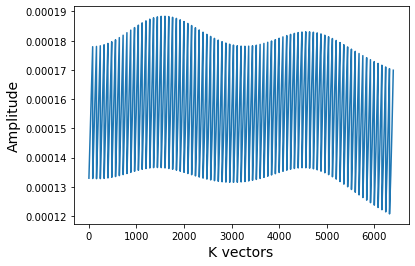

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline
plt.plot(normed_window_function)
plt.xlabel("K vectors",fontsize=14)
plt.ylabel("Amplitude",fontsize=14)
plt.show()
if baseline[1]==143:
    plt.savefig('(136,143),150Mhz-170Mhz,1000ns.png',dpi=300)
if baseline[1]==137:
    plt.savefig('(136,137),150Mhz-170Mhz,1000ns.png',dpi=300)
    
plt.show()

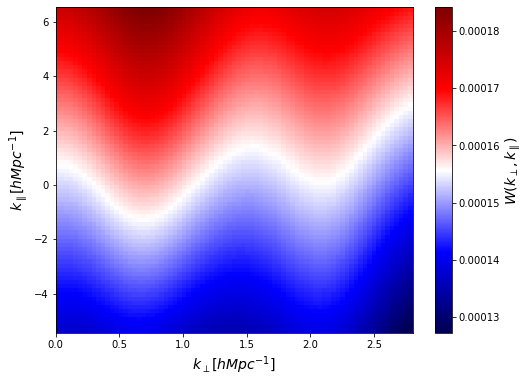

In [26]:
#Average window function
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.pcolormesh(np.linalg.norm(k_1d_perp_vec,axis=1),k_1d_parr,np.mean(np.real(z),axis=2), cmap='seismic')

cb = fig.colorbar(cax)
cb.set_label(r"$W(k_\perp,k_\parallel)$",fontsize=14)
ax.set_xlabel(r"$k_\perp [h Mpc^{-1}]$",fontsize=14)
ax.set_ylabel(r"$k_\parallel [h Mpc^{-1}]$",fontsize=14)

if baseline[1]==143:
    plt.savefig("Averaged(136,143),150Mhz-170Mhz,1000ns.png",dpi=300)
if baseline[1]==137:
    plt.savefig("Averaged(136,137),150Mhz-170Mhz,1000ns.png",dpi=300)

plt.show()

<IPython.core.display.Javascript object>


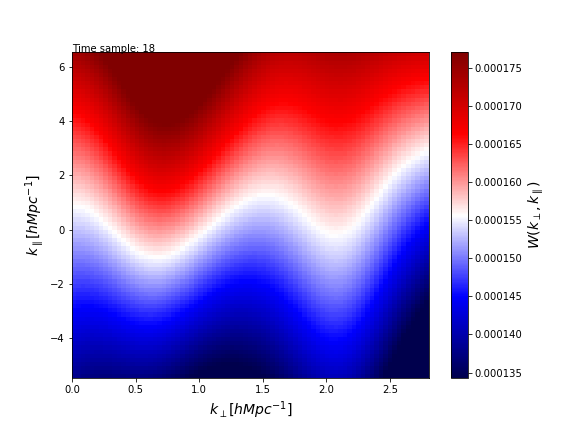

In [29]:
#Get the animated window function over all time samples.
%matplotlib nbagg
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.pcolormesh(np.linalg.norm(k_1d_perp_vec,axis=1),k_1d_parr,np.real(z[:-1, :-1, 0]), cmap='seismic')
time_text = plt.text(0, 1, 'Time sample: {}'.format(0), fontsize=10,transform=ax.transAxes) 

cb = fig.colorbar(cax)
cb.set_label(r"$W(k_\perp,k_\parallel)$",fontsize=14)
ax.set_xlabel(r"$k_\perp [h Mpc^{-1}]$",fontsize=14)
ax.set_ylabel(r"$k_\parallel [h Mpc^{-1}]$",fontsize=14)

def animate(i):
      
    cax.set_array(np.real(z[:-1, :-1, i]).flatten())
    time_text.set_text('Time sample: {}'.format(i)) 
    
anim = FuncAnimation(fig, animate, interval=100, frames=30, repeat=True,blit=False)


if baseline[1]==143:
    anim.save('(136,143),150Mhz-170Mhz,1000ns.mp4')
if baseline[1]==137:
    anim.save('(136,137),150Mhz-170Mhz,1000ns.mp4')

plt.show()